Detection of growing cores in GOES-16 ABI observations using a semi-Lagrangian framework

In [1]:
import os
import sys
import inspect
import itertools

import numpy as np
from numpy import ma
import pandas as pd
import xarray as xr
from datetime import datetime, timedelta
from dateutil.parser import parse as parse_date
from scipy import ndimage as ndi

import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import cartopy.crs as ccrs


# code from https://stackoverflow.com/questions/279237/import-a-module-from-a-relative-path?lq=1#comment15918105_6098238 to load a realitive folde from a notebook
# realpath() will make your script run, even if you symlink it :)
cmd_folder = os.path.realpath(os.path.abspath(os.path.split(inspect.getfile( inspect.currentframe() ))[0]))
if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder)
    
from utils import io, abi, glm
from utils.plotting import goes_figure
from utils.flow import Flow
from utils import legacy_flow as lf

# Filter some warnings because pyart doesn't work nicely with notebooks

import warnings
warnings.filterwarnings(
    action='ignore',
    category=DeprecationWarning
)

import warnings
warnings.filterwarnings(
    action='ignore',
    category=UserWarning
)

IO

In [2]:
# Load files
goes_data_path = './data/GOES16'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/jonesw/Downloads/dcc-detect-4e11a4adbc07.json'
start_date = datetime(2018,6,19,17)
days = timedelta(days=0.16)
dates = pd.date_range(start_date, start_date+days, freq='H', closed='left').to_pydatetime()

abi_files = list(sum([sorted(io.find_abi_files(date, satellite=16, product='MCMIP', view='C', mode=3, 
                                        save_dir=goes_data_path, 
                                        replicate_path=True, check_download=True, 
                                        n_attempts=1, download_missing=True))
                  for date in dates],[]))

# Test with some multichannel data
ds_slice = {'x':slice(500,2000), 'y':slice(250,1000)}
# Load a stack of goes datasets using xarray. Select a region over Northern Florida. (full file size in 1500x2500 pixels)
goes_ds = xr.open_mfdataset(abi_files, concat_dim='t', combine='nested').isel(ds_slice)
# Get dates
abi_dates = [io.get_goes_date(i) for i in abi_files]
print(len(abi_files))


48


In [3]:
# Extract fields and load into memory
wvd = goes_ds.CMI_C08 - goes_ds.CMI_C10
if hasattr(wvd, "compute"):
    wvd = wvd.compute()
bt = goes_ds.CMI_C13
if hasattr(bt, "compute"):
    bt = bt.compute()
swd = goes_ds.CMI_C13 - goes_ds.CMI_C15
if hasattr(swd, "compute"):
    swd = swd.compute()


Create Flow object

In [4]:
flow_kwargs = {'pyr_scale':0.5, 'levels':5, 'winsize':16, 'iterations':3, 
               'poly_n':5, 'poly_sigma':1.1, 'flags':256}

flow = Flow(bt, flow_kwargs=flow_kwargs, smoothing_passes=3)

Find growth regions

In [5]:
# Get growth_rate of the wvd field and find markers
from utils.detection import detect_growth_markers
wvd_growth, growth_markers = detect_growth_markers(flow, wvd)

/Users/jonesw/python/example_notebooks/utils/legacy_flow.py:136: RuntimeWarning: All-NaN axis encountered
  out_arr[t] = function(temp, 0, **kwargs)


In [6]:
print('Growth above threshold: area =', np.sum(wvd_growth.data>=0.5))
print('Detected markers: area =', np.sum(growth_markers.data!=0))
print('Detected markers: n =', growth_markers.data.max())


Growth above threshold: area = 54570
Detected markers: area = 35918
Detected markers: n = 263


Watershed over thick anvil

In [7]:
inner_field = wvd-swd+np.maximum(wvd_growth,0)*5

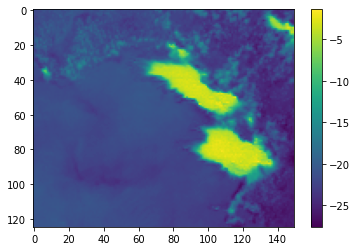

In [8]:
plt.imshow(inner_field[12])
plt.colorbar()

In [9]:
upper_threshold=-5
lower_threshold=-15
inner_field = np.maximum(np.minimum(inner_field, upper_threshold), lower_threshold)
inner_field.data[growth_markers!=0] = upper_threshold

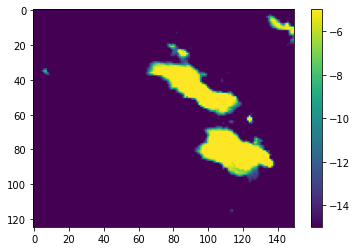

In [10]:
plt.imshow(inner_field[12])
plt.colorbar()

In [11]:
inner_edges = flow.sobel(inner_field, direction='uphill')

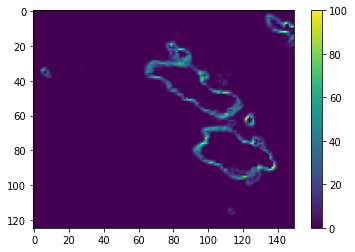

In [12]:
plt.imshow(inner_edges[12],vmax=100)
plt.colorbar()

In [13]:
s_struct = np.ones([1,3,3])
mask = ndi.binary_erosion(inner_field==lower_threshold, structure=s_struct, iterations=5, border_value=1)

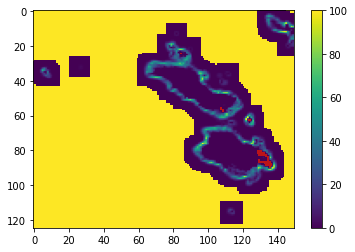

In [14]:
plt.imshow(inner_edges[12],vmax=100)
plt.colorbar()
plt.imshow(ma.array(mask[12], mask=mask[12]==0),vmin=0,vmax=1)
plt.imshow(ma.array(growth_markers[12]!=0, mask=growth_markers[12]==0),vmin=0,vmax=1.25,cmap='Reds')

In [15]:
inner_watershed = flow.watershed(inner_edges, growth_markers.data!=0, mask=mask, structure=ndi.generate_binary_structure(3,1))

In [16]:
s_struct = ndi.generate_binary_structure(2,1)[np.newaxis]
inner_watershed = ndi.binary_opening(inner_watershed, structure=s_struct)

In [17]:
inner_labels = flow.label(inner_watershed)

/Users/jonesw/python/example_notebooks/utils/legacy_flow.py:136: RuntimeWarning: All-NaN axis encountered
  out_arr[t] = function(temp, 0, **kwargs)


In [18]:
print('Detected anvils: area =', np.sum(inner_labels!=0))
print('Detected anvils: n =', inner_labels.max())


Detected anvils: area = 144452
Detected anvils: n = 2


Detect thin anvil region

In [19]:
outer_field = wvd+swd+np.maximum(wvd_growth,0)*5

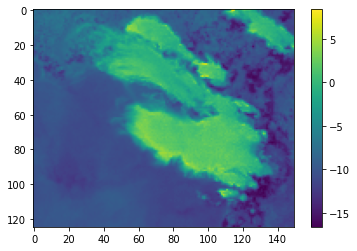

In [20]:
plt.imshow(outer_field[24])
plt.colorbar()

In [21]:
upper_threshold=0
lower_threshold=-10
outer_field = np.maximum(np.minimum(outer_field, upper_threshold), lower_threshold)
outer_field.data[inner_watershed] = upper_threshold

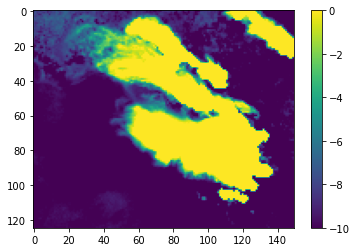

In [22]:
plt.imshow(outer_field[24])
plt.colorbar()

In [23]:
outer_edges = flow.sobel(outer_field, direction='uphill')

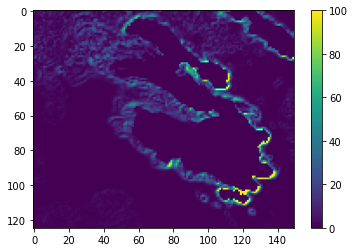

In [24]:
plt.imshow(outer_edges[24],vmax=100)
plt.colorbar()

In [25]:
s_struct = np.ones([1,3,3])
mask = ndi.binary_erosion(outer_field==lower_threshold, structure=s_struct, iterations=5, border_value=1)

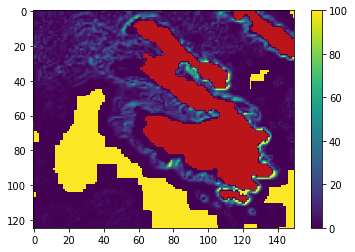

In [26]:
plt.imshow(outer_edges[24],vmax=100)
plt.colorbar()
plt.imshow(ma.array(mask[24], mask=mask[24]==0),vmin=0,vmax=1)
plt.imshow(ma.array(inner_watershed[24]!=0, mask=inner_watershed[24]==0),vmin=0,vmax=1.25,cmap='Reds')

In [27]:
outer_watershed = flow.watershed(outer_edges, inner_labels, mask=mask, structure=ndi.generate_binary_structure(3,1))
s_struct = ndi.generate_binary_structure(2,1)[np.newaxis]
outer_watershed = outer_watershed*ndi.binary_opening(outer_watershed!=0, structure=s_struct).astype(int)

In [28]:
print('Detected anvils: area =', np.sum(outer_watershed!=0))
print('Detected anvils: n =', outer_watershed.max())


Detected anvils: area = 249669
Detected anvils: n = 2


In [29]:
def edge_watershed(flow, field, markers, upper_threshold, lower_threshold, erode_distance=5):
    if isinstance(field, xr.DataArray):
        field = np.maximum(np.minimum(field.data, upper_threshold), lower_threshold)
    else:
        field = np.maximum(np.minimum(field, upper_threshold), lower_threshold)
    
    if isinstance(markers, xr.DataArray):
        markers = markers.data
    
    field[markers!=0] = upper_threshold
    
    s_struct = np.ones([1,3,3])
    mask = ndi.binary_erosion(field==lower_threshold, structure=s_struct, iterations=erode_distance, border_value=1)
    
    edges = flow.sobel(field, direction='uphill')
    
    watershed = flow.watershed(edges, markers, mask=mask, structure=ndi.generate_binary_structure(3,1))
    
    s_struct = ndi.generate_binary_structure(2,1)[np.newaxis]
    watershed = watershed*ndi.binary_opening(watershed!=0, structure=s_struct).astype(int)
    
    if isinstance(field, xr.DataArray):
        watershed = xr.DataArray(watershed, field.coords, field.dims)
    
    return watershed

In [30]:
del edge_watershed
from importlib import reload
from utils import detection
reload(detection)
from utils.detection import edge_watershed

In [7]:
# Watershed anvil regions connected to growth markers
from utils.detection import edge_watershed
from utils.analysis import filter_labels_by_length_and_mask
inner_watershed = edge_watershed(flow, wvd-swd+np.maximum(wvd_growth,0)*5, growth_markers!=0, -5, -15)
inner_labels = filter_labels_by_length_and_mask(flow.label(inner_watershed.data), 
                                                growth_markers.data!=0, 3)
print('Detected anvils: area =', np.sum(inner_labels!=0))
print('Detected anvils: n =', inner_labels.max())


/Users/jonesw/python/example_notebooks/utils/legacy_flow.py:136: RuntimeWarning: All-NaN axis encountered
  out_arr[t] = function(temp, 0, **kwargs)


Detected anvils: area = 6102418
Detected anvils: n = 34


In [8]:
outer_watershed = edge_watershed(flow, wvd+swd+np.maximum(wvd_growth,0)*5, inner_labels, 0, -10)
print('Detected thin anvils: area =', np.sum(outer_watershed!=0))


Detected thin anvils: area = 8627023


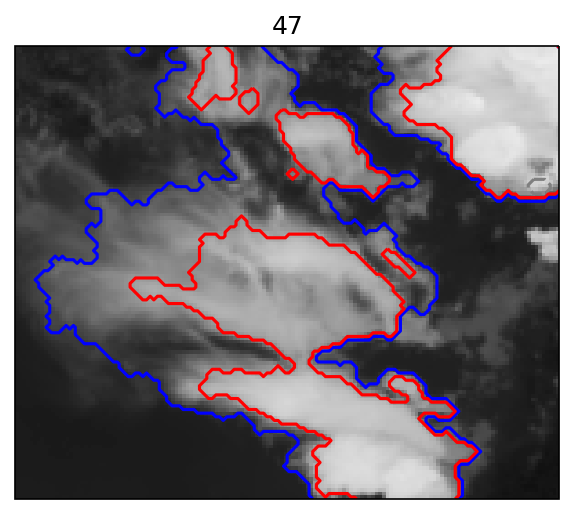

In [33]:
fig = goes_figure(goes_ds, dpi=150, figsize=(6,4))

ax1 = fig.subplot(111)
bt_img = ax1.imshow(bt[0], vmin=190, vmax=310, cmap='binary')
# growth_cntr = [ax1.contourf(wvd_diff_filtered[0], np.arange(0.1,1.1,0.1), extend='max', cmap='YlGnBu', alpha=0.5)]
label_cntrs = []
for j in np.unique(growth_markers.data[growth_markers!=0]):
    if j >= 10:
        ls = ['--']
    else:
        ls=[':']
    label_cntrs.append(ax1.contour(growth_markers[0]==j, [0.5], colors=['C0%1d'%(j%10)], linestyles=ls))
t = plt.title('0')

outer_cntr = [ax1.contour(test_outer_watershed[0]!=0, [0.5], colors=['b'])]
inner_cntr = [ax1.contour(test_inner_watershed[0]!=0, [0.5], colors=['r'])]

def init():
    return bt_img, label_cntrs, t, outer_cntr, inner_cntr

def animate(i):
    bt_img.set_data(bt[i])
    
#     for coll in growth_cntr[0].collections:
#         coll.remove()
#     growth_cntr[0] = ax1.contourf(wvd_diff_filtered[i], np.arange(0.1,1.1,0.1), extend='max', cmap='YlGnBu', alpha=0.5)
    
    for cntr in label_cntrs:
#         label_cntrs.remove(cntr)
        for coll in cntr.collections:
            try:
                coll.remove()
            except:
                pass
    
    for j in np.unique(growth_markers.data[growth_markers!=0]):
        if j >= 10:
            ls = ['--']
        else:
            ls=[':']
        label_cntrs.append(ax1.contour(growth_markers[i]==j, [0.5], colors=['C0%1d'%(j%10)], linestyles=ls))
    
    t.set_text(str(i))
    
    for coll in outer_cntr[0].collections:
        try:
            coll.remove()
        except:
            pass
    outer_cntr[0] = ax1.contour(test_outer_watershed[i]!=0, [0.5], colors=['b'])
    
    for coll in inner_cntr[0].collections:
        try:
            coll.remove()
        except:
            pass
    inner_cntr[0] = ax1.contour(test_inner_watershed[i]!=0, [0.5], colors=['r'])
    
    return bt_img, label_cntrs, t, outer_cntr, inner_cntr

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=48, 
                               interval=50, blit=False)
from IPython.display import HTML, Image, display
HTML(anim.to_jshtml())

In [9]:
# Get GLM data
# Process new GLM data
glm_files = sorted(sum([sorted(io.find_glm_files(date, satellite=16,
                                     save_dir=goes_data_path,
                                     replicate_path=True, check_download=True,
                                     n_attempts=1, download_missing=True))
                 for date in dates], []))
glm_files = {io.get_goes_date(i):i for i in glm_files}
glm_grid = glm.regrid_glm(glm_files, goes_ds, corrected=False)

In [10]:
from utils.validation import get_min_dist_for_objects, get_marker_distance

In [39]:
marker_distance = get_marker_distance(growth_markers, time_range=3)
anvil_distance = get_marker_distance(inner_labels, time_range=3)
glm_distance = get_marker_distance(glm_grid, time_range=3)

In [40]:
wvd_labels = filter_labels_by_length_and_mask(flow.label(wvd>=-5), wvd.data>=-5, 3)
print("warm WVD regions: n =",wvd_labels.max())
wvd_distance = get_marker_distance(wvd_labels, time_range=3)


/Users/jonesw/python/example_notebooks/utils/legacy_flow.py:136: RuntimeWarning: All-NaN axis encountered
  out_arr[t] = function(temp, 0, **kwargs)


warm WVD regions: n = 951


markers:
n = 263
0.5518156265597226
0.9619771863117871
total GLM flashes:  114203.0


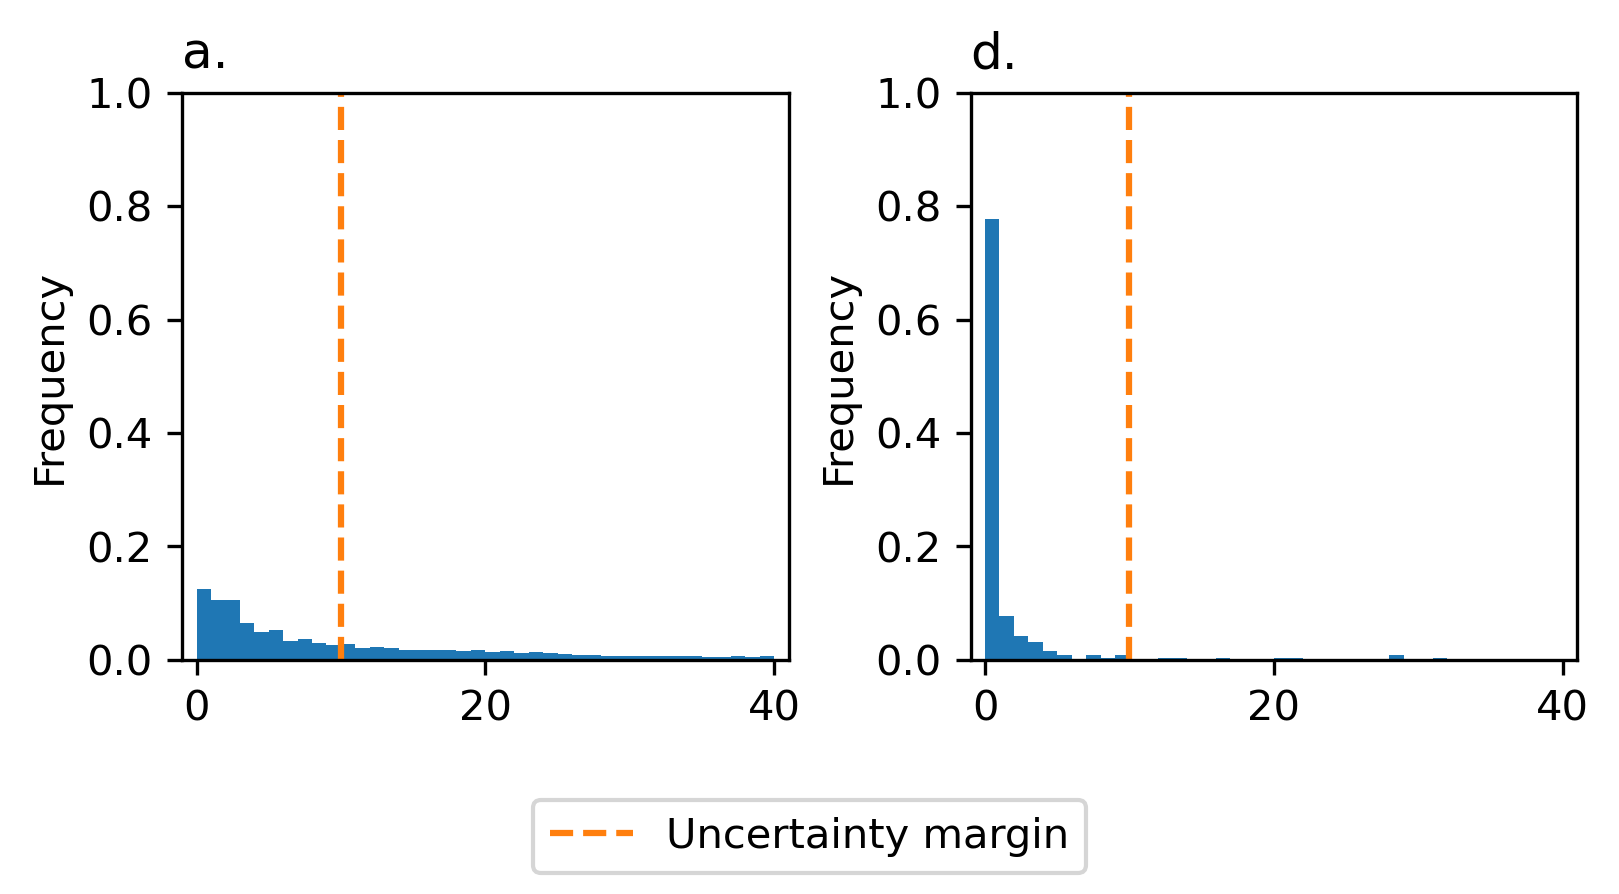

In [41]:
fig = plt.figure(dpi=300, figsize=(6,3))

plt.subplot(121)
h1 = plt.hist(marker_distance[glm_grid>0], 
         weights=glm_grid.data[glm_grid>0], bins=40, range=[0,40], density=True)
plt.plot([10,10],[0,1],c='C01',linestyle='--')
# plt.title('GLM flash distance to nearest marker')
plt.title('a.', loc='left')
plt.ylabel('Frequency')
plt.ylim([0,1.0])
plt.xlim([-1,41])
# plt.xlabel('Distance to marker (pixels)')

plt.subplot(122)
distances = get_min_dist_for_objects(glm_distance, growth_markers.data)[0]
h2 = plt.hist(distances, bins=40, range=[0,40], density=True)
plt.plot([10,10],[0,1],c='C01',linestyle='--')
# plt.title('Marker distance to nearest GLM flash')
plt.title('d.', loc='left')
plt.ylabel('Frequency')
plt.ylim([0,1.0])
plt.xlim([-1,41])
# plt.xlabel('Distance to GLM flash (pixels)')

import matplotlib.lines as mlines
fig.legend([mlines.Line2D([], [], color='C01', linestyle='--')], 
           ['Uncertainty margin'], loc='lower center')

plt.subplots_adjust(wspace=0.3, bottom=0.25)

print('markers:')
print('n =', growth_markers.data.max())
print(np.sum((marker_distance<=10)*glm_grid.data)/np.sum(glm_grid.data))
print(np.sum(np.sum(distances<=10)/distances.size))

print('total GLM flashes: ', np.sum(glm_grid.data))


markers:
n = 951
0.9910159978284283
0.32597266035751843
total GLM flashes:  114203.0


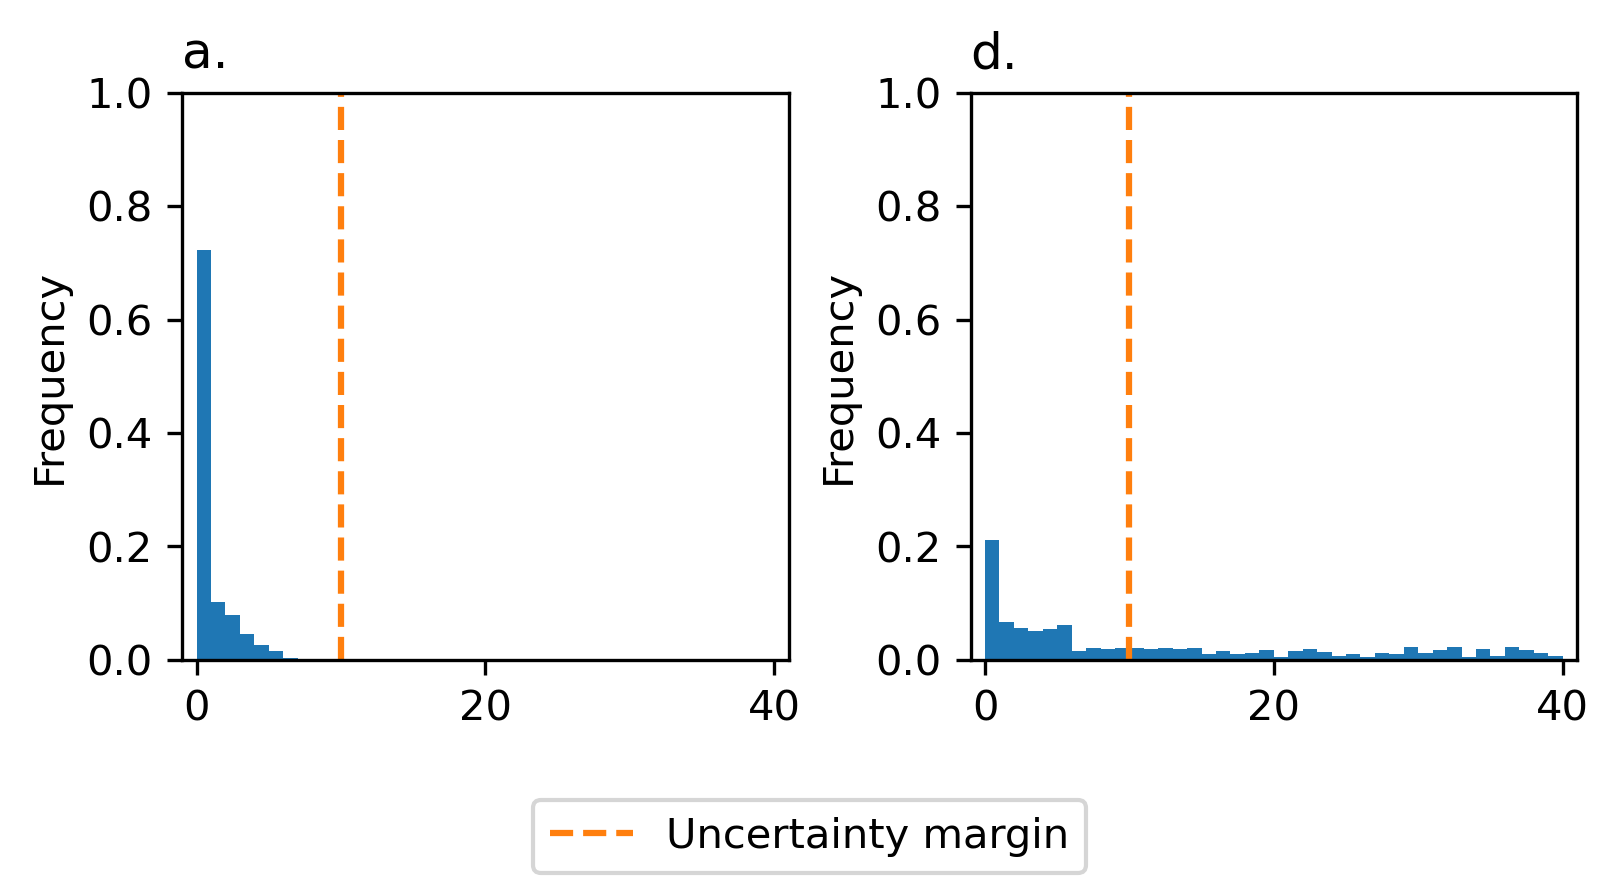

In [42]:
fig = plt.figure(dpi=300, figsize=(6,3))

plt.subplot(121)
h1 = plt.hist(wvd_distance[glm_grid>0], 
         weights=glm_grid.data[glm_grid>0], bins=40, range=[0,40], density=True)
plt.plot([10,10],[0,1],c='C01',linestyle='--')
# plt.title('GLM flash distance to nearest marker')
plt.title('a.', loc='left')
plt.ylabel('Frequency')
plt.ylim([0,1.0])
plt.xlim([-1,41])
# plt.xlabel('Distance to marker (pixels)')

plt.subplot(122)
distances = get_min_dist_for_objects(glm_distance, wvd_labels)[0]
h2 = plt.hist(distances, bins=40, range=[0,40], density=True)
plt.plot([10,10],[0,1],c='C01',linestyle='--')
# plt.title('Marker distance to nearest GLM flash')
plt.title('d.', loc='left')
plt.ylabel('Frequency')
plt.ylim([0,1.0])
plt.xlim([-1,41])
# plt.xlabel('Distance to GLM flash (pixels)')

import matplotlib.lines as mlines
fig.legend([mlines.Line2D([], [], color='C01', linestyle='--')], 
           ['Uncertainty margin'], loc='lower center')

plt.subplots_adjust(wspace=0.3, bottom=0.25)

print('markers:')
print('n =', wvd_labels.max())
print(np.sum((wvd_distance<=10)*glm_grid.data)/np.sum(glm_grid.data))
print(np.sum(np.sum(distances<=10)/distances.size))

print('total GLM flashes: ', np.sum(glm_grid.data))


markers:
n = 34
0.973687206115426
0.8823529411764706
total GLM flashes:  114203.0


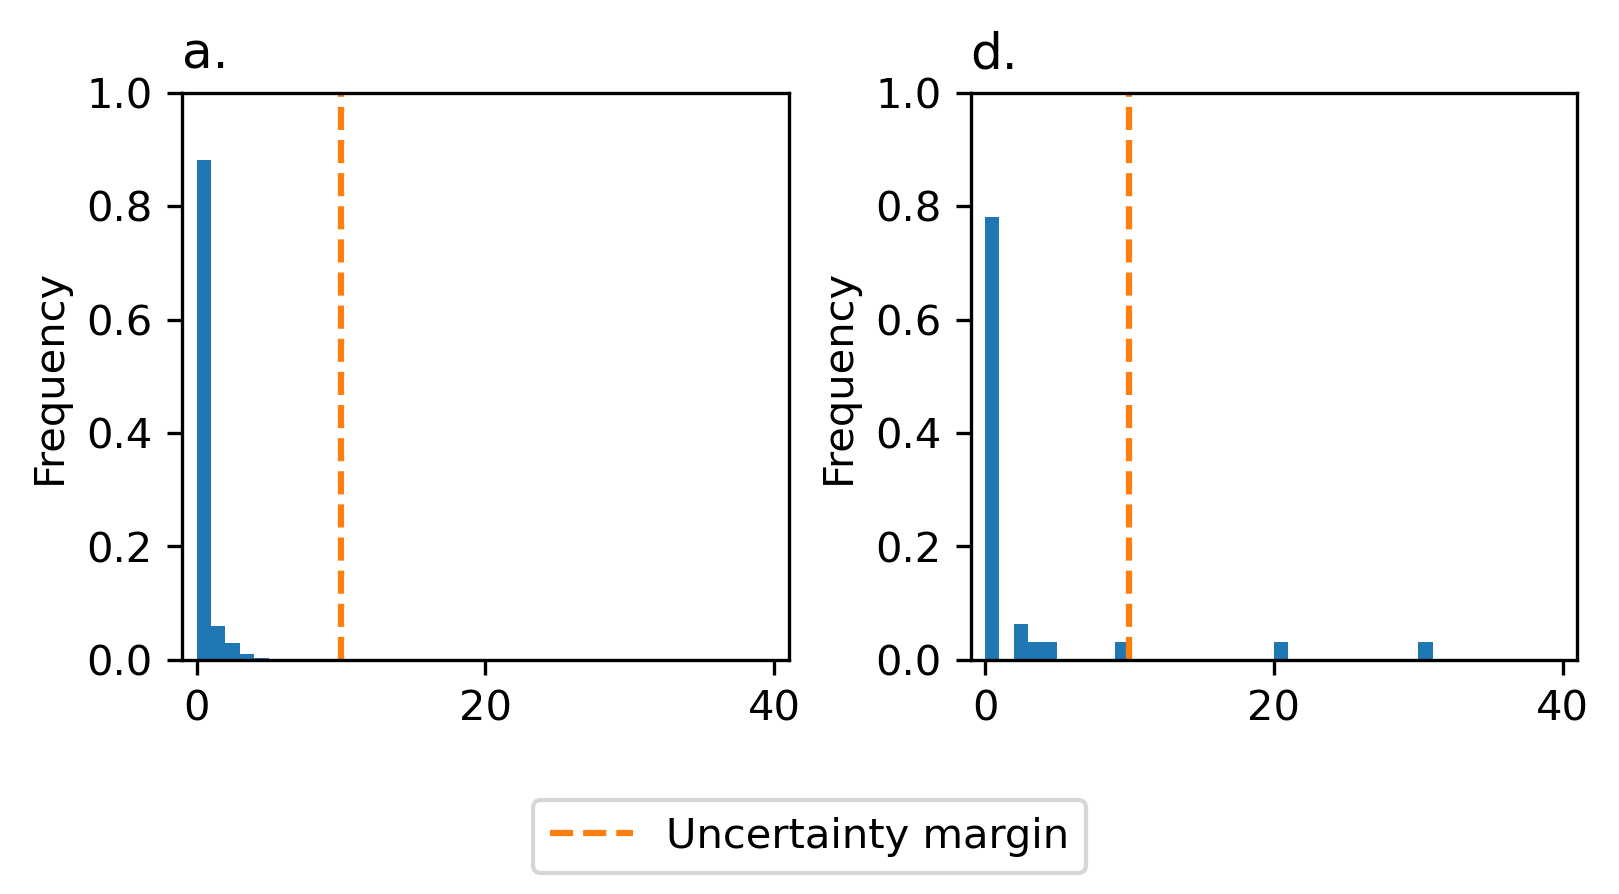

In [43]:
fig = plt.figure(dpi=300, figsize=(6,3))

plt.subplot(121)
h1 = plt.hist(anvil_distance[glm_grid>0], 
         weights=glm_grid.data[glm_grid>0], bins=40, range=[0,40], density=True)
plt.plot([10,10],[0,1],c='C01',linestyle='--')
# plt.title('GLM flash distance to nearest marker')
plt.title('a.', loc='left')
plt.ylabel('Frequency')
plt.ylim([0,1.0])
plt.xlim([-1,41])
# plt.xlabel('Distance to marker (pixels)')

plt.subplot(122)
distances = get_min_dist_for_objects(glm_distance, inner_labels)[0]
h2 = plt.hist(distances, bins=40, range=[0,40], density=True)
plt.plot([10,10],[0,1],c='C01',linestyle='--')
# plt.title('Marker distance to nearest GLM flash')
plt.title('d.', loc='left')
plt.ylabel('Frequency')
plt.ylim([0,1.0])
plt.xlim([-1,41])
# plt.xlabel('Distance to GLM flash (pixels)')

import matplotlib.lines as mlines
fig.legend([mlines.Line2D([], [], color='C01', linestyle='--')], 
           ['Uncertainty margin'], loc='lower center')

plt.subplots_adjust(wspace=0.3, bottom=0.25)

print('markers:')
print('n =', inner_labels.max())
print(np.sum((anvil_distance<=10)*glm_grid.data)/np.sum(glm_grid.data))
print(np.sum(np.sum(distances<=10)/distances.size))

print('total GLM flashes: ', np.sum(glm_grid.data))


markers:
n = 263
0.5467982452299851
0.03802281368821292
WVD:
n = 951
0.9909984851536299
0.6782334384858044
anvil:
n = 34
0.9735821300666356
0.11764705882352933
total GLM flashes:  114203.0


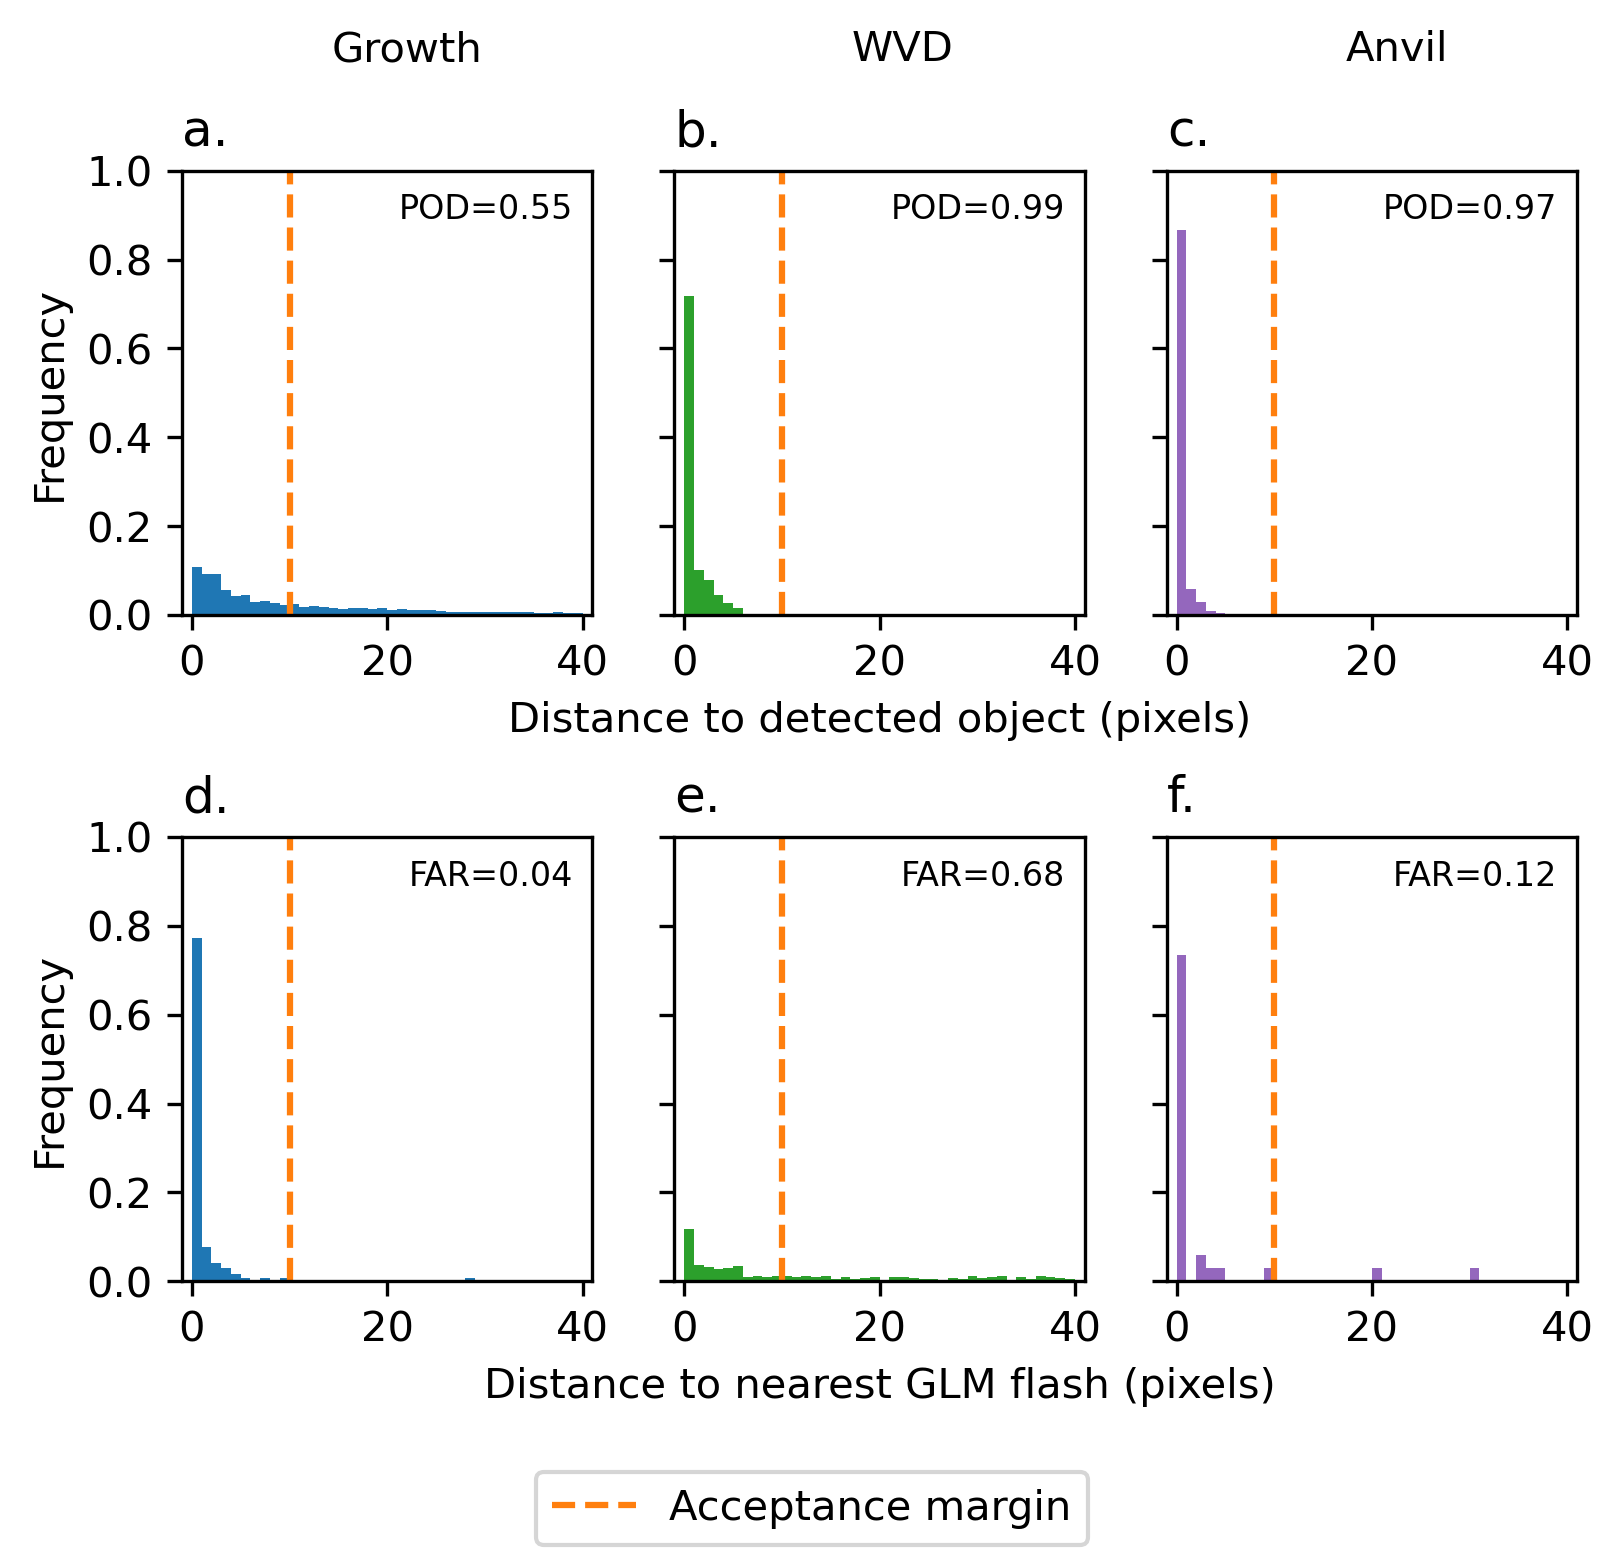

In [68]:
fig = plt.figure(dpi=300, figsize=(6,5.25))

plt.subplot(231)
marker_pod = np.histogram(marker_distance[glm_grid>0], 
                          weights=glm_grid.data[glm_grid>0], 
                          bins=40, 
                          range=[0,40])[0]/np.sum(glm_grid.data[glm_grid>0])
plt.bar(np.arange(0,40), marker_pod,
        width=1, align='edge')

# h1 = plt.hist(marker_distance[glm_grid>0], 
#          weights=glm_grid.data[glm_grid>0], bins=40, range=[0,40], density=True)
plt.plot([10,10],[0,1],c='C01',linestyle='--')
# plt.title('GLM flash distance to nearest marker')
plt.title('a.', loc='left')
plt.ylabel('Frequency')
plt.ylim([0,1.0])
plt.xlim([-1,41])
# plt.xlabel('Distance to marker (pixels)')
plt.text(39,0.95,
         'POD='+str(np.round(np.sum(marker_pod[:10]),2)), 
         horizontalalignment='right', verticalalignment='top',
         fontsize=8)

plt.subplot(232)
wvd_pod = np.histogram(wvd_distance[glm_grid>0], 
                       weights=glm_grid.data[glm_grid>0], 
                       bins=40, 
                       range=[0,40])[0]/np.sum(glm_grid.data[glm_grid>0])
plt.bar(np.arange(0,40), wvd_pod,
        width=1, align='edge', color='C02')

# h3 = plt.hist(wvd_distance[glm_grid>0], 
#          weights=glm_grid.data[glm_grid>0], bins=40, range=[0,40], density=True, color='C02')
plt.plot([10,10],[0,1],c='C01',linestyle='--')
# plt.title('GLM flash distance to WVD')
plt.title('b.', loc='left')
# plt.ylabel('Frequency')
plt.ylim([0,1.0])
plt.yticks([0,0.2,0.4,0.6,0.8,1], labels=['','','','','',''])
plt.xlim([-1,41])
plt.xlabel('Distance to detected object (pixels)')
plt.text(39,0.95,
         'POD='+str(np.round(np.sum(wvd_pod[:10]),2)), 
         horizontalalignment='right', verticalalignment='top',
         fontsize=8)

plt.subplot(233)
anvil_pod = np.histogram(anvil_distance[glm_grid>0], 
                         weights=glm_grid.data[glm_grid>0], 
                         bins=40, 
                         range=[0,40])[0]/np.sum(glm_grid.data[glm_grid>0])
plt.bar(np.arange(0,40), anvil_pod,
        width=1, align='edge', color='C04')

# h5 = plt.hist(anvil_distance[glm_grid>0], 
#          weights=glm_grid.data[glm_grid>0], bins=40, range=[0,40], density=True, color='C04')
plt.plot([10,10],[0,1],c='C01',linestyle='--')
# plt.title('GLM flash distance to nearest anvil')
plt.title('c.', loc='left')
# plt.ylabel('Frequency')
plt.yticks([0,0.2,0.4,0.6,0.8,1], labels=['','','','','',''])
plt.ylim([0,1.0])
plt.xlim([-1,41])
# plt.xlabel('Distance to detected anvil (pixels)')
plt.text(39,0.95,
         'POD='+str(np.round(np.sum(anvil_pod[:10]),2)), 
         horizontalalignment='right', verticalalignment='top',
         fontsize=8)

plt.subplot(234)
growth_far = np.histogram(get_min_dist_for_objects(glm_distance, growth_markers)[0], 
                         bins=40, 
                         range=[0,40])[0]/growth_markers.data.max()
plt.bar(np.arange(0,40), growth_far,
        width=1, align='edge', color='C00')

# h2 = plt.hist(get_min_dist_for_objects(glm_distance, growth_markers)[0], bins=40, range=[0,40], density=True)
plt.plot([10,10],[0,1],c='C01',linestyle='--')
# plt.title('Marker distance to nearest GLM flash')
plt.title('d.', loc='left')
plt.ylabel('Frequency')
plt.ylim([0,1.0])
plt.xlim([-1,41])
# plt.xlabel('Distance to GLM flash (pixels)')
plt.text(39,0.95,
         'FAR='+str(np.round(1-np.sum(growth_far[:10]),2)), 
         horizontalalignment='right', verticalalignment='top',
         fontsize=8)


plt.subplot(235)
wvd_far = np.histogram(get_min_dist_for_objects(glm_distance, wvd_labels)[0], 
                         bins=40, 
                         range=[0,40])[0]/wvd_labels.max()
plt.bar(np.arange(0,40), wvd_far,
        width=1, align='edge', color='C02')

# h4 = plt.hist(get_min_dist_for_objects(glm_distance, wvd_labels)[0], bins=40, range=[0,40], density=True, color='C02')
plt.plot([10,10],[0,1],c='C01',linestyle='--')
# plt.title('WVD distance to nearest GLM flash')
plt.title('e.', loc='left')
# plt.ylabel('Frequency')
plt.ylim([0,1.0])
plt.yticks([0,0.2,0.4,0.6,0.8,1], labels=['','','','','',''])
plt.xlim([-1,41])
plt.xlabel('Distance to nearest GLM flash (pixels)')
plt.text(39,0.95,
         'FAR='+str(np.round(1-np.sum(wvd_far[:10]),2)), 
         horizontalalignment='right', verticalalignment='top',
         fontsize=8)

plt.subplot(236)
anvil_far = np.histogram(get_min_dist_for_objects(glm_distance, inner_labels)[0], 
                         bins=40, 
                         range=[0,40])[0]/inner_labels.max()
plt.bar(np.arange(0,40), anvil_far,
        width=1, align='edge', color='C04')

# h6 = plt.hist(get_min_dist_for_objects(glm_distance, inner_labels)[0], bins=40, range=[0,40], density=True, color='C04')
plt.plot([10,10],[0,1],c='C01',linestyle='--')
# plt.title('Anvil distance to nearest GLM flash')
plt.title('f.', loc='left')
# plt.ylabel('Frequency')
plt.ylim([0,1.0])
plt.yticks([0,0.2,0.4,0.6,0.8,1], labels=['','','','','',''])
plt.xlim([-1,41])
# plt.xlabel('Distance to GLM flash (pixels)')
plt.text(39,0.95,
         'FAR='+str(np.round(1-np.sum(anvil_far[:10]),2)), 
         horizontalalignment='right', verticalalignment='top',
         fontsize=8)

fig.legend([mlines.Line2D([], [], color='C01', linestyle='--')], 
           ['Acceptance margin'], loc='lower center')

fig.text(0.525, 0.95, 'WVD', ha='center', va='baseline')
fig.text(0.25, 0.95, 'Growth', ha='center', va='baseline')
fig.text(0.8, 0.95, 'Anvil', ha='center', va='baseline')


# plt.subplots_adjust(wspace=0.05, bottom=0.05, top=0.85, left=0.075, right=0.95)
plt.subplots_adjust(hspace=0.5, bottom=0.175)

print('markers:')
print('n =', growth_markers.data.max())
print(np.sum(marker_pod[:10]))
print(1-np.sum(growth_far[:10]))

print('WVD:')
print('n =', wvd_labels.max())
print(np.sum(wvd_pod[:10]))
print(1-np.sum(wvd_far[:10]))

print('anvil:')
print('n =', inner_labels.max())
print(np.sum(anvil_pod[:10]))
print(1-np.sum(anvil_far[:10]))

print('total GLM flashes: ', np.sum(glm_grid.data))


In [63]:
np.round(96.78,1)

96.8

Object `ax1.text` not found.
